In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import numpy.linalg as la
from matplotlib.colors import LogNorm
from scipy import signal
from skimage.transform import rescale
import matplotlib.pyplot as plt
import utils
import scipy
import skimage
from sklearn.neighbors import KDTree

In [ ]:
# To connect to drive for input images. We just used local images

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#Declare global variables (Hyperparameters)
L = 1
total_levels = 4
kappa = 1

# kernel3 denotes gaussian weighting for a 3 x 3 
kernel3 = np.array([[1,2,1],
                    [2,4,2],
                    [1,2,1]])
kernel3 = kernel3 * 1/16

# kernel5 denotes gaussian weighting for a 5 x 5
kernel5 = np.array([[1,4,7,4,1],
                    [4,16,26,16,4],
                    [7,26,41,26,7],
                    [4,16,26,16,4],
                    [1,4,7,4,1]])
kernel5 = kernel5 * 1/273

In [ ]:
#Brute Force Solution for coarsest level and corner and edge pixels of each level

def bruteforce(total_feature_vectors, Al_pyramid, Alf_pyramid,Bl_pyramid,Blf_pyramid, l, q):
  feature_B, weights_B = GetFeatureVectors(q[0],q[1],l, Bl_pyramid, Blf_pyramid)
  feature_B = np.array(feature_B)
  idx = np.where(np.array(weights_B)!=0)
  feature_B = feature_B[idx]
  mindist = -1
  for y in range(Al_pyramid[l].shape[0]):
    for x in range(Al_pyramid[l].shape[1]):
      if y>1 and y<Al_pyramid[l].shape[0]-2 and x>1 and x<Al_pyramid[l].shape[1]-2:
        feature_A = total_feature_vectors[l][(y-2)*(Al_pyramid[l].shape[1]-4)+(x-2)]
      else:
        feature_A, weights_A = GetFeatureVectors(y,x,l, Al_pyramid, Alf_pyramid)
      feature_A = np.array(feature_A)[idx]
      diff = feature_B - feature_A
      dist = np.dot(diff,diff)
      if mindist == -1 or dist < mindist:
        mindist = dist
        pix = (y,x)
  return pix

In [ ]:
#Main function to return filtered B
def CreateImageAnalogy(A, A_filtered, B, B_filtered):
    #Convert each image to YIQ color space
    A_yiq = YIQConvert(A)
    Af_yiq = YIQConvert(A_filtered)
    B_yiq = YIQConvert(B)
    Bf_yiq = YIQConvert(B_filtered)

    #Create YIQ pyramids
    A_pyramids = create_pyramid(A_yiq, total_levels)
    Af_pyramids = create_pyramid(Af_yiq, total_levels)
    B_pyramids = create_pyramid(B_yiq, total_levels)
    Bf_pyramids = create_pyramid(Bf_yiq, total_levels)

    Al_pyramid, Alf_pyramid, Bl_pyramid,Blf_pyramid = [],[],[],[]

    #Get the luminance pyramids
    for i in range(total_levels): 
      Al_pyramid.append(A_pyramids[i][:,:,0])
      Alf_pyramid.append(Af_pyramids[i][:,:,0])
      Bl_pyramid.append(B_pyramids[i][:,:,0])
      Blf_pyramid.append(Bf_pyramids[i][:,:,0])

    #Initialize the search structures, which can also be used as a cache
    total_feature_vectors = []
    total_weight_vectors = []
    for level in range(total_levels):
      features, weights = InitializeTree(Al_pyramid, Alf_pyramid, level)
      total_feature_vectors.append(features)
      total_weight_vectors.append(weights)

    #Initialize Blf_pyramid:
    # Blf_pyramid = []
    # for i in range(total_levels):
    #   Blf_pyramid.append(B_pyramid[i].shape))


    s = {}    # collection of points indexed by q that map to p, s(q) = p
    for level in range(total_levels-1,-1,-1): # for each level , from coarsest to finest, do:
      print (level)
      if level < total_levels-1:
        KDtree = KDTree(total_feature_vectors[level])               #scipy.spatial.cKDTree(total_feature_vectors[level]) 
      for row in range(Blf_pyramid[level].shape[0]):      # for each pixel q ∈ B', in scan-line order, do:
        for col in range(Blf_pyramid[level].shape[1]):
          #Find the best matching pixel
          if row > 1 and row < Blf_pyramid[level].shape[0] - 2 and col > 1 and col < Blf_pyramid[level].shape[1] - 2 and level < total_levels-1:
            pixel = BestMatch(KDtree, total_feature_vectors, total_weight_vectors, Al_pyramid, Alf_pyramid,Bl_pyramid,Blf_pyramid, s, level, (row,col))
          else:
            pixel = bruteforce(total_feature_vectors, Al_pyramid, Alf_pyramid,Bl_pyramid,Blf_pyramid, level, (row,col))
          Blf_pyramid[level][row][col] = Alf_pyramid[level][int(pixel[0])][int(pixel[1])] #Set the feature vector of B' equal to that of A'
          s[(row,col)] = pixel                                                            #Store the best matching pixel in S(correspondence map)
            
    
    #Take luminance channel from finest level of pyramid copy I and Q channels over
    image = np.zeros((B.shape[0],B.shape[1],3))
    image[:,:,0] =  Blf_pyramid[0]
    image[:,:,1:] = B_yiq[:,:,1:]

    return Blf_pyramid, image

#Finds the Best Match for a pixel in a level of B filtered
def BestMatch(KDtree, total_feature_vectors, total_weight_vectors, Al_pyramid,Alf_pyramid,Bl_pyramid,Blf_pyramid,s,l,q):
  #B_filtered is partially synthesized
  #s = source information level, collection of points indexed by q that map to p, s(q) = p
  #l = level
  #q = the pixel being synthesized in B_filtered, tuple of row and col

  pixel_approximate = BestApproximateMatch(KDtree, total_feature_vectors, Al_pyramid,Alf_pyramid, Bl_pyramid, Blf_pyramid, l, q)
  pixel_coherence = BestCoherenceMatch(total_feature_vectors, total_weight_vectors, Al_pyramid, Alf_pyramid, Bl_pyramid, Blf_pyramid, s, l ,q)

  if (pixel_coherence) == (None, None):
        return pixel_approximate

  feature_B, weights_B = GetFeatureVectors(q[0],q[1],l, Bl_pyramid, Blf_pyramid)

  # Get features and weights from cache 
  features = total_feature_vectors[l]
  weights = total_weight_vectors[l]
  one_d_approx = int(pixel_approximate[0]-2)*(Al_pyramid[l].shape[1]-4) + int(pixel_approximate[1]-2)
  one_d_coherence = int(pixel_coherence[0]-2)*(Al_pyramid[l].shape[1]-4) + int(pixel_coherence[1]-2)
  feature_approx = features[int(one_d_approx)]
  weights_approx = weights[int(one_d_approx)] 
  feature_coherence = features[int(one_d_coherence)]
  weights_coherence = weights[int(one_d_coherence)]

  d_coherence = la.norm(Distance(feature_approx, feature_B, weights_approx, weights_B),2)
  d_approx = la.norm(Distance(feature_coherence, feature_B, weights_coherence, weights_B),2)
  kappanew = -1

  if (d_coherence <= d_approx*(1+(2**(l - total_levels))*kappanew)):
    return pixel_coherence 
  return pixel_approximate

#Finds Best Match for a pixel based on Coherence
def BestCoherenceMatch(total_feature_vectors, total_weight_vectors, Al_pyramid, Alf_pyramid, Bl_pyramid, Blf_pyramid, s, l ,q):
  #s = source information level
  #l = level
  #q = the pixel being synthesized in Bf_pyramid[l], tuple of row and col
  #total_feature_vectors = cache of feature vectors of A from tree intiailization, l X (# of pixels at that level) X 68
  #total_weight_vectors = cache of weights of A from tree intiailization, l X (# of pixels at that level) X 68

  r_star = (None,None)  #r*, tuple of best coherence match

  initial_row = q[0]
  initial_col = q[1]
  min = np.inf

  #loop through 5x5 neighborhood around q, looking for best match
  flag = False
  for row in range(-2,1):
    if (flag):
      break
    for col in range(-2,3):
        if (row == 0) and (col == 1):
          flag = True
          break
        r = (initial_row + row, initial_col + col)
        #check if pixel is in bounds:
        if (r[0] >= 0) and (r[0] < Blf_pyramid[l].shape[0]) and (r[1] >= 0) and (r[1] < Blf_pyramid[l].shape[1]):
          if (r in s): #check if pixel has already been synthesized
            potential_point = (int(s[r][0] + (q[0] - r[0])), int(s[r][1] + (q[1]-r[1])))
            if (potential_point[0] >= 0) and (potential_point[0] < Blf_pyramid[l].shape[0]) and (potential_point[1] >= 0) and (potential_point[1] < Blf_pyramid[l].shape[1]):
              # Get feature_A and weights_A from the caches:
              total_feature = total_feature_vectors[l]
              total_weight = total_weight_vectors[l]
              one_d_coord = (potential_point[0]-2)*(Alf_pyramid[l].shape[1]-4) + potential_point[1] - 2
              if int(one_d_coord) < len(total_feature):
                feature_A = total_feature[int(one_d_coord)]
                weights_A = total_weight[int(one_d_coord)]
                feature_B,weights_B = GetFeatureVectors(q[0],q[1], l, Bl_pyramid, Blf_pyramid)
                # compute weighted norm of feature_A and feature_B:
                cost = la.norm(Distance(feature_A,feature_B,weights_A,weights_B),2)
                if (cost < min):
                  min = cost
                  r_star = r

  if (r_star) == (None, None):
        return r_star
  best_match = (int(s[r_star][0] + (q[0]-r_star[0])),int(s[r_star][1] + (q[1]-r_star[1]))) #s(r*) +(q − r*)
  return best_match

#Finds Best Match of a pixel based on nearest neighbour
def BestApproximateMatch(KDtree, total_feature_vectors, Al_pyramid, Alf_pyramid, Bl_pyramid, Blf_pyramid, l, q):
  
  feature_B, weights_B = GetFeatureVectors(q[0],q[1], l, Bl_pyramid, Blf_pyramid)
  result = KDtree.query([feature_B], k=1)
  index = result[1]
  row = (index / (Al_pyramid[l].shape[1]-4)) + 2
  col = (index % (Al_pyramid[l].shape[1]-4)) + 2

  return (row,col)

In [ ]:
#Helper Function: Gets the features from a particular level and filtered or unfiltered version based on parameters (contributes about 1/4 of the feature for each pixel)
def GetFeatures(row,col, l, neighborhood_size, luminance_pyramid):
  features = []
  weights = []
  kernel = 0
  # set kernel to corresponding gaussian kernel either 5 x 5 or 3 x 3
  if (neighborhood_size == 2): 
    kernel = kernel5
  else:
    kernel = kernel3
  for y_off in range(-neighborhood_size, neighborhood_size + 1):
    for x_off in range(-neighborhood_size, neighborhood_size + 1):
      x_pos = col + x_off
      y_pos = row + y_off
      if (x_pos >= 0) and (x_pos < luminance_pyramid[l].shape[1]) and (y_pos >= 0) and (y_pos < luminance_pyramid[l].shape[0]):
        features.append(luminance_pyramid[l][int(y_pos)][int(x_pos)])
        weights.append(kernel[y_off + neighborhood_size][x_off + neighborhood_size])
      else:
        features.append(0)
        weights.append(0)
  return features, weights

#Helper Function: Same as GetFeatures just for special case of getting from current level's filtered image as it contributes only the partial neighbourhood
def GetFeaturesPrime(row,col, l, neighborhood_size, luminance_pyramid):
  features = []
  weights = []
  kernel = 0
  # set kernel to corresponding gaussian kernel either 5 x 5 or 3 x 3
  if (neighborhood_size == 2): 
    kernel = kernel5
  else:
    kernel = kernel3
  flag = False
  for y_off in range(-neighborhood_size, 1):
    if (flag):
      break
    for x_off in range(-neighborhood_size, neighborhood_size + 1):
      if (y_off == 0) and (x_off == 1):
        flag = True
        break
      x_pos = col + x_off
      y_pos = row + y_off
      if (x_pos >= 0) and (x_pos < luminance_pyramid[l].shape[1]) and (y_pos >= 0) and (y_pos < luminance_pyramid[l].shape[0]):
        features.append(luminance_pyramid[l][int(y_pos)][int(x_pos)])
        weights.append(kernel[y_off + neighborhood_size][x_off + neighborhood_size])
      else:
        features.append(0)
        weights.append(0)
  return features, weights

#Computes the complete feature of a given pixel in either A or B
def GetFeatureVectors(row, col, level, luminance_pyramid, luminance_pyramid_prime):
  features = []
  weights = [] 
  #Compute features at fine level
  fl_features,fl_weights = GetFeatures(row,col,level, 2, luminance_pyramid)
  fl_features_prime,fl_weights_prime = GetFeaturesPrime(row,col,level, 2, luminance_pyramid_prime)
  #Compute features at coarse level if possible
  if (level + 1 != total_levels):
    cl_features,cl_weights = GetFeatures(int(row/2),int(col/2),level + 1,1, luminance_pyramid)
    cl_features_prime,cl_weights_prime = GetFeatures(int(row/2),int(col/2),level + 1,1, luminance_pyramid_prime)
    features = fl_features_prime + fl_features + cl_features_prime + cl_features
    weights = fl_weights_prime + fl_weights + cl_weights_prime + cl_weights
  else:
    features = fl_features_prime + fl_features + [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    weights = fl_weights_prime + fl_weights + [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  return features, weights


In [ ]:
#Low Pass and High Pass Filters
#Only used to create filtered image A' if testing on blur filter

def lowPass(im1, sigma_low):
  low_pass_gaussian = utils.gaussian_kernel(sigma_low,3*sigma_low)
  low_passed_image = cv2.filter2D(im1, -1, low_pass_gaussian)
  return low_passed_image

def highPass(im2, sigma_high):
   high_pass_gaussian = utils.gaussian_kernel(sigma_high,3*sigma_high)
   high_passed_image = im2 -  cv2.filter2D(im2,-1,high_pass_gaussian)
   return high_passed_image

In [ ]:
#Convert from RGB to YIQ color space
def YIQConvert(image):
  return skimage.color.rgb2yiq(image)

#Creates the Gaussian Pyramid
def create_pyramid(img, L): 
  G = img.copy()
  gpA = [G]
  for i in range(L - 1):
      G = cv2.pyrDown(G)
      gpA.append(G)
  return gpA

#Intialize the feature Vectors for Internal Pixels
def InitializeTree(Al_pyramid, Alf_pyramid, l):
  total_feature_vector = []
  total_weights_vector = []
  for row in range(2,Al_pyramid[l].shape[0]-2):
    for col in range(2,Al_pyramid[l].shape[1]-2):
      features, weights = GetFeatureVectors(row, col, l, Al_pyramid, Alf_pyramid)
      total_feature_vector.append(features)
      total_weights_vector.append(weights)
  return total_feature_vector, total_weights_vector

#Distance between 2 features
def Distance(feature_A,feature_B, weights_A,weights_B):
  #Function that normalizes vectors and computes weighted distance

  dist = np.zeros(len(feature_A))
  #Computed weighted distance
  for i in range(len(feature_A)): 
    dist[i] = (feature_A[i] * weights_A[i]) - (feature_B[i] * weights_B[i])
  return dist

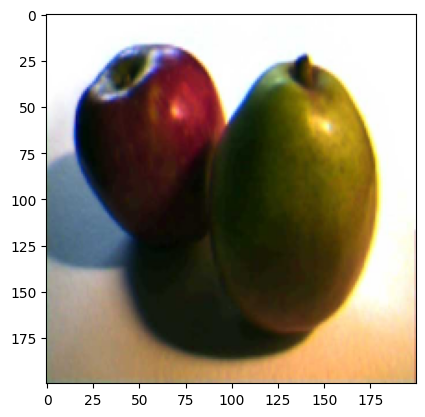

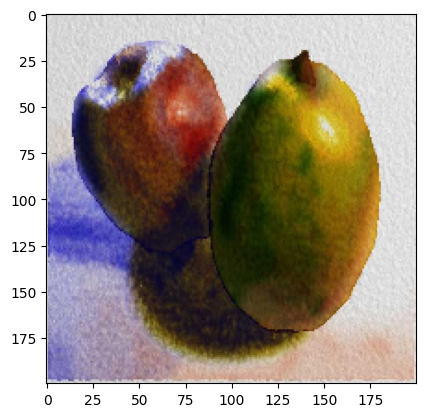

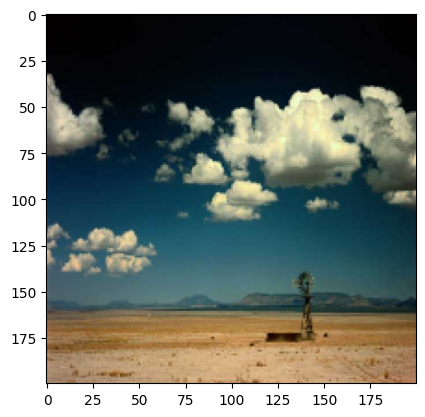

In [ ]:
#Setup input images
n = 200
A = cv2.imread('fruit.jpg')[:,:,(2,1,0)]
A = cv2.resize(A,(n,n))
# Af = lowPass(A, 1)
Af = cv2.imread('fruit_filtered.jpg')[:,:,(2,1,0)]
Af = cv2.resize(Af, (n,n))
B = cv2.imread('landscape.jpg')[:,:,(2,1,0)]
B = cv2.resize(B, (n,n))
Bf = np.zeros(B.shape)

plt.figure()
plt.imshow(A)

plt.figure()
plt.imshow(Af)

plt.figure()
plt.imshow(B)

In [ ]:
# Call create Image Analogy (Bf is just an image of zeros)
B_filtered,image = CreateImageAnalogy(A,Af,B,Bf)

3
2
1
0


done


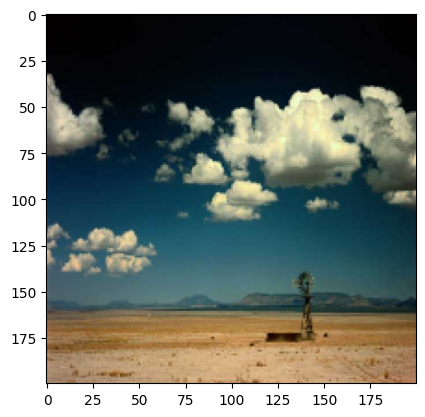

<Figure size 640x480 with 0 Axes>

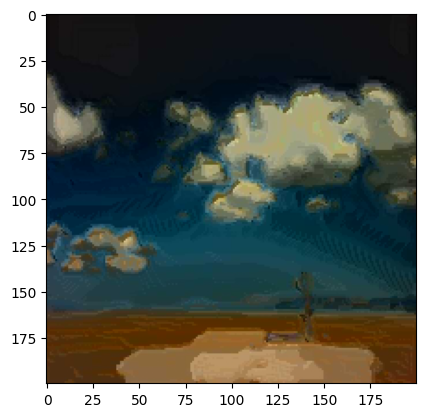

In [ ]:
plt.figure()
plt.imshow(B)

plt.figure()

# Just for TESTING
# Viewing the entire resulting pyramid
# for i in range(total_levels):
#   plt.figure()
#   plt.imshow(B_filtered[i])
#   plt.imshow(Bf_pyramids[i], cmap = 'gray')

Bf_rgb = skimage.color.yiq2rgb(image)

plt.figure()
plt.imshow(Bf_rgb)

print("done")